# EDA

In [1]:
#import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import cv2

#image and output formatting
import PIL
from PIL import Image
from tabulate import tabulate

#dir manip libraries
import os, sys, glob, pathlib, tempfile
from pathlib import Path
from collections import defaultdict

#import label encoding
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight

#keras for model output customization
import keras
from keras import layers, ops

#tensorflow tools for model building
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Rescaling
from tensorflow.keras.optimizers import Adam, SGD

# Custom functions (this works, finally)
from pyTools.utils import *

# Print out versions for important tools
print("Pandas version:", pd.__version__)
print("TensorFlow version:", tf.__version__)
print("Pillow version:", PIL.__version__)

Pandas version: 2.1.4
TensorFlow version: 2.16.1
Pillow version: 10.2.0


In [2]:
# Define the path to your Google Drive folder containing the images
data_dir = Path("../ML_Asm2_ProjFiles/trafficsigns_dataset/trafficsigns_dataset")

# Ensure the directory exists
if not data_dir.exists():
    raise ValueError(f"Directory {data_dir} does not exist. Please check the path.")

In [3]:
image_count = len(list(data_dir.glob('*/**/*.png')))
print(image_count)

3699


In [4]:
print_directory_tree(data_dir)

├───trafficsigns_dataset/
    ├───diamond/
        ├───rightofway/
    ├───hex/
        ├───stop/
    ├───round/
        ├───bicycle/
        ├───limitedtraffic/
        ├───noentry/
        ├───noparking/
        ├───roundabout/
        ├───speed/
        ├───trafficdirective/
        ├───traveldirection/
    ├───square/
        ├───continue/
        ├───crossing/
        ├───laneend/
        ├───parking/
    ├───triangle/
        ├───giveway/
        ├───warning/


In [5]:
print_summary(data_dir)

+------------------+------------------+
|    Directory     | Number of Images |
+------------------+------------------+
|    rightofway    |       282        |
|       stop       |        43        |
|     bicycle      |       285        |
|  limitedtraffic  |       125        |
|     noentry      |       375        |
|    noparking     |       242        |
|    roundabout    |        98        |
|      speed       |       316        |
| trafficdirective |       195        |
| traveldirection  |       124        |
|     continue     |       199        |
|     crossing     |        95        |
|     laneend      |       118        |
|     parking      |       276        |
|     giveway      |       231        |
|     warning      |       695        |
+------------------+------------------+


In [6]:
data = image_dataset_from_directory(
    data_dir,
    seed = 1000,
    batch_size = 36,
    image_size = (28,28),
    color_mode = "grayscale",
)

Found 3699 files belonging to 5 classes.


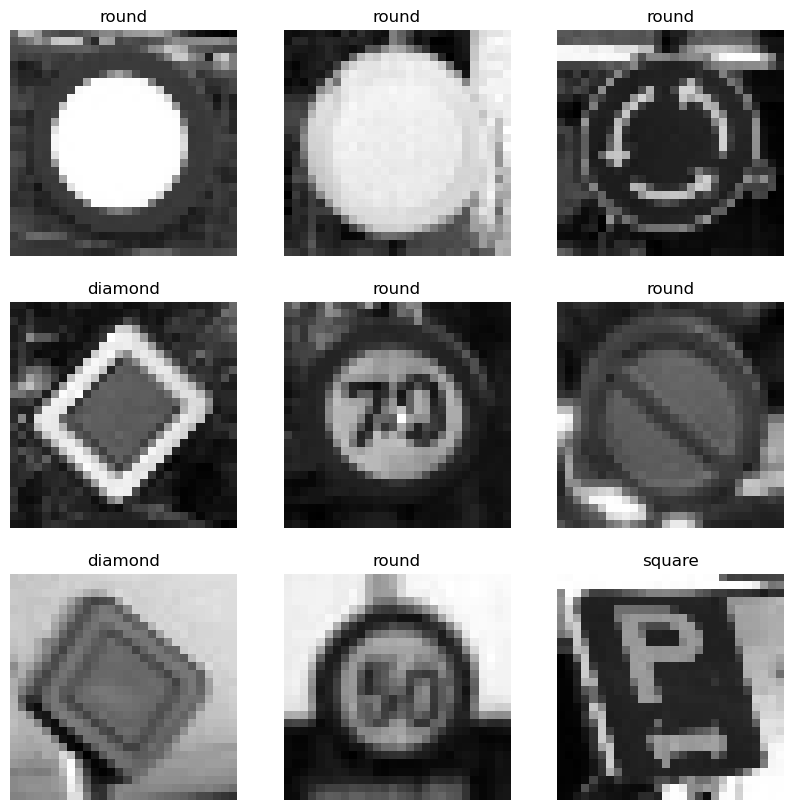

In [7]:
class_names = data.class_names
plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap = 'gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
# Sample valid image extensions
valid_extensions = ('.png', '.jpg')

# Dictionary to store the total image count for each "big directory"
image_count_dict = defaultdict(int)

# Traverse through the entire directory structure
for dirpath, dirnames, filenames in os.walk(data_dir):
    # Get the immediate parent directory name
    base_dir = os.path.basename(os.path.dirname(dirpath))
    
    # Count the valid image files in the current directory
    num_images = sum(1 for filename in filenames if filename.lower().endswith(valid_extensions))
    
    # Ignore the base dataset directory
    if base_dir == data_dir.name:
        continue  # Skip if it's the top-level dataset folder
    
    # Accumulate the count for the corresponding base directory
    image_count_dict[base_dir] += num_images

# Step 1: Generate a list of class labels based on the image count dictionary
labels = []

for class_name, count in image_count_dict.items():
    # Add the class label repeated by the number of images in that class
    labels.extend([class_name] * count)

In [9]:
image_count_dict

defaultdict(int,
            {'diamond': 282,
             'hex': 43,
             'round': 1760,
             'square': 688,
             'triangle': 926})

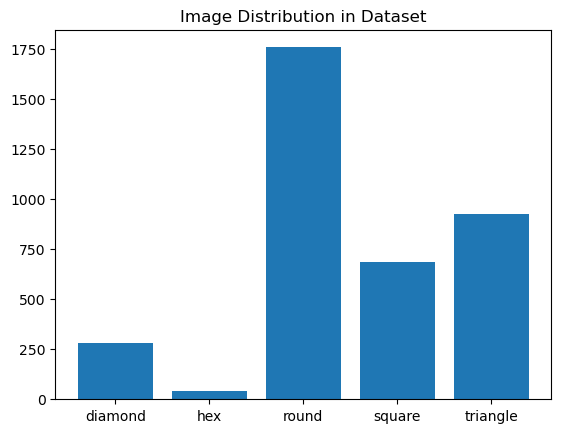

In [10]:
names = list(image_count_dict.keys())
values = list(image_count_dict.values())

plt.bar(range(len(image_count_dict)), values, tick_label=names)
plt.title("Image Distribution in Dataset")
plt.show()

## Notes: 
- Noticeable imbalance in dataset. 'Round' class has substantially larger number of images comparing to other classes, while 'Hex' has noticeably little. Usage of this dataset would later led to model being extremely overfit to data (since all data are default), and heavily inclined to predicting round class. 